# Exploring and controlling the latent space of deep generative models



## <font color=#33EBFF>Introduction

Deep generative models is a hot topic in Machine Learning these days. Most of those models follow the same method to generate images (or sound, ...) which is to start from a space called **latent space**, pick an element (vector) and pass it through a decoder to get a generated image. 

The latent space is often assimilated to a "white noise" because it is hard to find an exploitable structure in it. But sometimes we want to modify something in the generated image and to do that, we need to explore and control the latent space.
>For example if our model generate cats, we may want to change the color, the size or the lenth of the tail.
Here is an oversimplyfied example with a simple  and well structured 2D latent space.
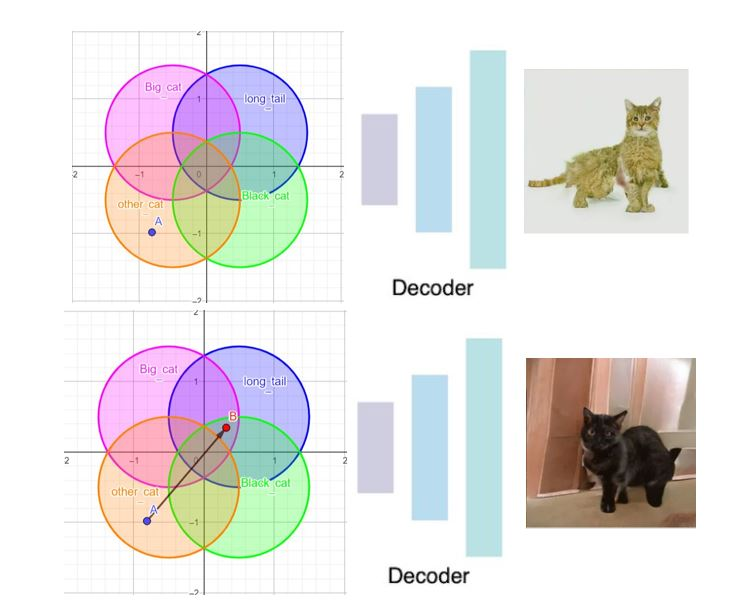

In our project we try to do the same thing with a popular generation model : **variationnal autoencoder** (VAE) and with the **dSprites dataset**.

1. We start by creating our VAE model trained on the dSprites dataset.

2. Then we'll proceed to an analyse of the latent space to look for some exploitable structure.

3. Once found, we'll try to modify some characteristics of the generated image



## <font color=#33EBFF>Initializing the notebook

###Import library

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import functional as F
import shutil

!pip install pwlf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pwlf


my_seed = 0
np.random.seed(my_seed)
torch.manual_seed(my_seed)

###Import Drive and select current path

In [ ]:
# The directory with this file and the data file
path=''   

colab=True #@param {type:"boolean"}         
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path='drive/MyDrive/Projet_VAE_dSprites/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Looking for GPU

In [ ]:
#@title Looking for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


## <font color=#33EBFF>dSprites data



The dSprites dataset comes from https://github.com/deepmind/dsprites-dataset (dSprites: Disentanglement testing Sprites dataset, Loic Matthey and Irina Higgins and Demis Hassabis and Alexander Lerchner, 2017)


Description of the dataset

>dSprites is a dataset of 2D shapes procedurally generated from 6 ground truth independent latent factors. These factors are color, shape, scale, rotation, x and y positions of a sprite.<br><br>All possible combinations of these latents are present exactly once, generating N = 737280 total images.<br><br>**Latent factor values**
<br>Color: white
<br>Shape: square, ellipse, heart
<br>Scale: 6 values linearly spaced in [0.5, 1]
<br>Orientation: 40 values in [0, 2 pi]
<br>Position X: 32 values in [0, 1]
<br>Position Y: 32 values in [0, 1]
<br><br>We varied one latent at a time (starting from Position Y, then Position X, etc), and sequentially stored the images in fixed order. Hence the order along the first dimension is fixed and allows you to map back to the value of the latents corresponding to that image.
<br><br>We chose the latents values deliberately to have the smallest step changes while ensuring that all pixel outputs were different. No noise was added.
<br><br>The data is a NPZ NumPy archive with the following fields:
<br>imgs: (737280 x 64 x 64, uint8) Images in black and white.
<br>latents_values: (737280 x 6, float64) Values of the latent factors.
<br>latents_classes: (737280 x 6, int64) Integer index of the latent factor values. Useful as classification targets.
<br>metadata: some additional information, including the possible latent values.
<br><br>dataset = { 'imgs' : ... , 'latents_values' : ... , 'latents_classes' : ... , 'metadata' : ... }




###Load data class

In [ ]:
class dSpritesDataset(Dataset):
    """dSprites dataset"""

    def __init__(self, transform=None):
 
        # Load the dataset dSprites
        dataset_z = np.load(path+'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', allow_pickle=True, encoding='bytes')
        
   
        
        self.imgs = dataset_z['imgs']
        self.latents_values = dataset_z['latents_values']
        self.latents_classes = dataset_z['latents_classes']
        self.metadata = dataset_z['metadata'][()]
        self.transform = transform

    def __len__(self):
      
        return len(self.imgs)

    def __getitem__(self, idx):

        sample = self.imgs[idx].astype(np.float32)
        latent_val = self.latents_values[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, latent_val

def load_dsprites():
    """
    Load our dataset and transform each image array into tensor
    """
    dataset = dSpritesDataset(transform=transforms.ToTensor())
    return dataset

def split_data(dataset,val_split=[0.8,0.1,0.1], shuffle=True, seed=42, batch_size=64):

    """
    Prepare our dataset into 3 dataloaders : train data, test data, validation data
    
    Parameters
    ----------
    dataset : dict
    val_split : list
        proportion of [train data,test_data,validation data] we want
    shuffle : bool
    seed : int
    batch_size : int
    
    Returns
    -------
    train_loader 
        Load train data randomly gathered in batchs
    test_loader 
        Load test data randomly gathered in batchs
    val_loader
        Load validation data randomly gathered in batchs
    """

    # Create data indices for train, test, validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split_val = int(np.floor((1-val_split[2]) * dataset_size))
    split_test = int(np.floor(val_split[0] * dataset_size))
    
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
        
    train_indices, test_indices, val_indices = indices[:split_test], indices[split_test:split_val], indices[split_val:]
    
    # Create data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    

    return train_loader, test_loader, val_loader


###Load data

In [ ]:
dataset = load_dsprites()
train_loader, test_loader, val_loader = split_data(dataset,val_split=[0.8,0.1,0.1], shuffle=True, seed=42, batch_size=64)

shape of list(train_loader) : nb_batch x 2(img,latent_values) x batch_size x 1(channel ?) x 1(one image) x (64 x 64)(image size)

###Get the values of different parameters of the image

In [ ]:

def get_values(data):
    dic={}
    for i in range(6):
        s=set()
        for lat in data.latents_values:
            s.add(lat[i])
        dic[latent_index[i]]=s
    return(dic)

latent_index=['color','shape','scale','orientation','position X','position Y']
latent_dic=get_values(dataset)

### Visualize data

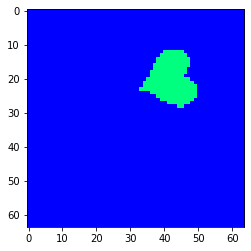

In [ ]:


data,_=next(iter(train_loader))

def to_img(x):
    if torch.is_tensor(x):
        x = x.cpu().detach().numpy()
    x = x.reshape([-1, 64, 64])
    return x  

b=plt.imshow(to_img(data[0])[0])

## <font color=#33EBFF>Our VAE model

Beware : we exchanged "validation" and "test" notion in the notebook .

###Generative model
We have a dataset $\mathcal{X} ~;~ \mathcal{X} \subset \mathbb{R}^D $. And we want to generate exemples similar to the elements of our dataset $\mathcal{X}$.

We consider a distribution ${P(X)}$ over $ \mathbb{R}^D$ that is likely to produce samples like those in $\mathcal{X}$, and we want to calculate it numericaly.

We consider as well the latent space $\mathcal{Z} \subset \mathbb{R}^K$, with $K \ll D$. We have : $$ {p(x; \theta)} = \int_{\mathbf{z} \in \mathcal{Z}} p(\mathbf{x} | \mathbf{z} ; \theta )~p(\mathbf{z})~ d\mathbf{z} $$

We want to maximize ${p(x; \theta)}$ for the elements  $\mathbf{x} \in \mathcal{X}$ *w.r.t* $\theta$. For that , we maximise the log-likelihood , we note $\mathcal{X} = \left\{ \mathbf{x}_{n} ; n =1,2,...,N \right\}$.

we have :
$$\max _{\theta}\left\{ \frac{1}{N} \sum_{n=1}^{N} \ln p\left(\mathbf{x}_{n} ; \theta\right)\right\}$$

$p\left(\mathbf{x}_{n} ; \theta\right)$ cannot be comuted analytically, but we have for any distribution $q(\mathbf{z} | \mathbf{x} ; \phi)$ :
$$
\ln p(\mathbf{x} ; \theta)=\mathcal{L}(\mathbf{x} ; \phi, \theta)+D_{\mathrm{KL}}\Big(q(\mathbf{z} | \mathbf{x} ; \phi) ~\|~ p(\mathbf{z} | \mathbf{x} ; \theta)\Big)
$$
where $\mathcal{L}(\mathbf{x} ; \phi, \theta)$ is the evidence lower bound (ELBO), defined by
$$
\mathcal{L}(\mathbf{x} ; \phi, \theta)=\mathbb{E}_{q(\mathbf{z} | \mathbf{x} ; \phi)} \Big[ ~\ln p(\mathbf{x} |  \mathbf{z} ; \theta)~ \Big]-D_{\mathrm{KL}}\Big(q(\mathbf{z} | \mathbf{x} ; \phi)~ \| ~p(\mathbf{z} ; \theta)\Big) 
$$
with $D_{\mathrm{KL}}$ is the Kullback-Leibler divergence.

Insead of maximising $p\left(\mathbf{x} ; \theta\right)$ we maximise the ELBO $\mathcal{L}(\mathbf{x} ; \phi, \theta)$ which can be computed, the loss function is the negative ELBO.

In **our case** the dataset $\mathcal{X}$ is the `dSpritesDataset` loaded before and  $D = 64 \times 64$.
 

###Variational autoencoder
Let $\mathbf{x} \in \mathbb{R}^D$ and $\mathbf{z} \in \mathbb{R}^K$ be two random vectors (with $K \ll D$).

In our case, $D~$ is the dimension of the images $D = 64 \times 64$ and $K = 6~$ is number of latent factors.

**Generative model**: We consider the following generative model:


$$p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$$

$$p(\mathbf{x} | \mathbf{z} ; \theta ) = \mathcal{N}\Big( \boldsymbol{\mu}_\theta(\mathbf{z}), \text{diag}\left\{ \mathbf{v}_\theta(\mathbf{x}) \right\}
 \Big)$$

The decoder outputs $\boldsymbol{\mu}_\theta(\mathbf{z})$ and $\text{diag}\left\{ \mathbf{v}_\theta(\mathbf{x})\right\}$. In our case we use a neural network as a decoder and $\theta$ are the parametres of the NN (weights and biases).

**Recognition model**: We consider the following recognition model:

$$q(\mathbf{z} | \mathbf{x}; \phi) = \mathcal{N}\Big( \boldsymbol{\mu}_\phi(\mathbf{x}), \text{diag}\left\{ \mathbf{v}_\phi(\mathbf{x}) \right\} \Big)$$

The encoder outputs $\boldsymbol{\mu}_\phi(\mathbf{x})$ and $\mathbf{v}_\phi(\mathbf{x})$. In our case we use a neural network as a encoder and $\phi$ are the parametres of the NN (weights and biases).

**The ELBO** : the ELBO can be written after simplification: for $\mathbf{x} \in \mathcal{X}$
$$
\begin{aligned}
\mathcal{L}(\mathbf{x} ; \phi, \theta)=&-\frac{1}{2} \sum_{d=1}^{D}\left[\ln \left(v_{d, \theta}(\tilde{\mathbf{z}})\right)+\frac{\left(x_{d}-\mu_{d, \theta}(\tilde{\mathbf{z}})\right)^{2}}{v_{d, \theta}(\tilde{\mathbf{z}})}\right] \\
&+\frac{1}{2} \sum_{k=1}^{K}\left[\ln v_{k, \phi}(\mathbf{x})-\mu_{k, \phi}^{2}(\mathbf{x})-v_{k, \phi}(\mathbf{x})\right]
\end{aligned}
$$
where $\tilde{\mathbf{z}}$ is drawn from $q(\mathbf{z} \mid \mathbf{x} ; \phi)$ using the reparametrization trick:
$$\mathbf{z}_{r}=\mu_{\phi}(\mathbf{x})+\operatorname{diag}\left\{\mathbf{v}_{\phi}(\mathbf{x})\right\}^{1 / 2} \epsilon_{r},
$$
where $\boldsymbol{\epsilon}_{r}$ is drawn from $\mathcal{N}(\mathbf{0}, \mathbf{I})$.

and $\mathbf{x} = [x_1,...,x_D]$ , $\boldsymbol{\mu}_\phi(\mathbf{x}) = \Big[\mu_{1, \phi}(\mathbf{x}),...,\mu_{K, \phi}(\mathbf{x})\Big]$ and $\text{diag}\left\{ \mathbf{v}_\phi(\mathbf{x}) \right\} = \Big[v_{1, \phi}(\mathbf{x}),...,v_{K, \phi}(\mathbf{x})\Big]$ . 

**Loss function** : The loss function is the sum of the negative ELBO over the training dataset: 
$$\mathit{L (\theta, \phi) = - \frac{1}{N} \sum_{n=1}^{N} \mathcal{L}\left(\mathbf{x}_{n} ; \phi, \theta\right) }$$
Using the reparametrization trick, the loss function is differentiable *w.r.t* $(\theta, \phi)$.


###Utils functions

In [ ]:
class Flatten(nn.Module):
    """Do the same thing as torch.nn.Flatten"""
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    """Do the same thing as torch.nn.UnFlatten"""
    def __init__(self, n_channels):
        super(UnFlatten, self).__init__()
        self.n_channels = n_channels
    def forward(self, input):
        size = int((input.size(1) // self.n_channels)**0.5)
        return input.view(input.size(0), self.n_channels, size, size)

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    Save a mid-trained or trained model parameters into a file
    
    Parameters
    ----------
    state : dict = {'epoch': The next epoch to train, 'test_loss_min': The loss on the test data, 'state_dict': neural parameters of our model,'optimizer':for Adam (learning rate change with epochs)}
        checkpoint we want to save 
    is_best : bool
        is this the best checkpoint based on test loss
    checkpoint_path : str
        path to save checkpoint
    best_model_path : str
        path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    """
    Load a trained model parameters
    
    Parameters
    ----------
    checkpoint_path : stg
        path where we saved checkpoint
    model : nn.Module
        model that we want to load checkpoint parameters into       
    optimizer : an object from torch module (po envie de chercher)
        optimizer we defined in previous training

    Returns
    -------
    See save_ckp function
    """

    # load checkpoint
    checkpoint = torch.load(checkpoint_fpath,map_location=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    test_loss_min = checkpoint['test_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], test_loss_min

###Some parameters to set

In [ ]:

#@markdown Latent space dimension
z_dim=20 #@param {type:"integer"}


#@markdown Data reconstruction coefficient
k_recons=1.0 #@param {type:"number"}


#@markdown Kullback-Leibler coefficient
k_kl=0.1 #@param {type:"number"}

#@markdown Number of batchs before printing advancement and train loss 
log_interval=1000 #@param {type:"integer"}


#@markdown Number of epochs we want ot train
n_epochs=10 #@param {type:"integer"}

start_epochs=1

### VAE model

In [ ]:
class VAE_Conv(nn.Module):
    """
    Model of CNN for Variational Autoencoder 

    Parameters
    ----------
    z_dim : int
        latent space dimension
    img_channels : int
        3 for RGB 
        1 for nuances de gris 
    img_size : int
    """
    def __init__(self, z_dim=20, img_channels=1, img_size=64):
        super(VAE_Conv, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 8, (3,3), stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, (4,4), stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, (5,5), stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, (5,5), stride=2, padding=2),
            nn.ReLU(),
            Flatten()
        )

        # output size depends on input image size
        # h_dim = conv network to dense size
        demo_input = torch.ones([1,img_channels,img_size,img_size])
        h_dim = self.encoder(demo_input).shape[1]

        # map to latent z
        self.fc11 = nn.Linear(h_dim, z_dim)
        self.fc12 = nn.Linear(h_dim, z_dim)

        # decoder
        self.fc2 = nn.Linear(z_dim, h_dim)
        n_channels = 64
        self.decoder = nn.Sequential(
            UnFlatten(n_channels),
            nn.ConvTranspose2d(64, 32, (6,6), stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, (6,6), stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, (6,6), stride=2, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, (5,5), stride=1, padding=2),
            nn.Sigmoid()
        )

    def encode(self, x):
        """
        Encode our initial image x

        Return
        ------
        self.fc11 mean vector
        self.fc12 logspread diag vector
        """
        h = self.encoder(x)
        return self.fc11(h), self.fc12(h)

    def reparameterize(self, mu, logvar):
        """
        Return a randomly chosen vector z of the latent space following N(mu,logvar)
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        """
        Return the decoded image from z 
        """
        img = self.decoder(self.fc2(z))
        return img

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

  
def loss_function(recon_x, x, mu, logvar,k_recons=1,k_kl=0.1):
    """
    Loss fonction of our VAE model

    Parameters
    ----------
    recon_x : tensor
        batch of recontructed images
    x : tensor
        batch of real image
    mu : tensor
        batch of mean
    logvar : tensor 
        batch of logvar
    k_recons : float
        reconstruction coefficient 
    k_kl : float
        kl coefficient

    Return
    ------
    Loss on the batch
    """
    
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return k_recons*BCE + k_kl*KLD


###Training settings

In [ ]:
# device to train our network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE_Conv().to(device)

# optimizer chosen
optimizer = optim.Adam(model.parameters(), lr=1e-3)

checkpoint_path = path+'current_checkpoint.pt'
best_model_path = path+'current_best_model.pt'

loaders={'train':train_loader,'test':test_loader}

###Train function

In [ ]:
def train(start_epochs=1, n_epochs=2, test_loss_min_input=np.Inf, loaders=loaders, model=model, optimizer=optimizer, checkpoint_path=checkpoint_path, best_model_path=best_model_path):
    """
    Finally the train function, will train our VAE model
    
    Parameters
    ----------
    start_epochs : int
    n_epochs : int
    test_loss_min_input : float
        test loss at the beginning
    loaders : dict
        our data
    model : nn.Module
    optimizer : toujours flemme
    checkpoint_path : str
    best_model_path : str
    """

    # initialize tracker for minimum validation loss
    test_loss_min = test_loss_min_input 
    
    for epoch in range(start_epochs, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        test_loss = 0.0
        
        ###################
        # train the model #
        ###################

        model.train()
        for batch_idx, (data, _) in enumerate(loaders['train']):
            # move to GPU if we can
            data = data.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            recon_batch, mu, logvar = model(data)
            # calculate the batch loss
            loss = loss_function(recon_batch, data, mu, logvar,k_recons,k_kl)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a parameter update
            optimizer.step()
            # add the training loss
            train_loss += loss.item()
            # print the loss and the progression once log_interval reached
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.sampler),
                  100. * batch_idx / len(train_loader),
                  loss.item() / len(data)))
        
        ######################    
        # validate the model #
        ######################
        
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['test']):
            # move to GPU
            data = data.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            recon_batch, mu, logvar = model(data)
            # calculate the batch loss
            loss = loss_function(recon_batch, data, mu, logvar,k_recons,k_kl)
            # update average test loss 
            test_loss += loss.item()

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f}'.format(
            epoch, 
            train_loss/len(loaders['train'].sampler),
            test_loss/len(loaders['test'].sampler)
            ))
        
        # create checkpoint variable and add important data
        checkpoint = {
            'epoch': epoch + 1,
            'test_loss_min': test_loss/len(loaders['test'].sampler),
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        
        # save checkpoint
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
        # save the model if test loss has decreased
        if test_loss <= test_loss_min:
            print('Test loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(test_loss_min,test_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            test_loss_min = test_loss

### Train the model or load a trained model

In [ ]:
#@markdown I want to restart the training from the beginning and I am fully responsible for what will happen afterwards (~15 minutes each epochs using colab GPUs)
confirm=False #@param {type:"boolean"}

if confirm :
    train(start_epochs,n_epochs)

#@markdown ---
#@markdown Load the current model in checkpoint path ?

load=True #@param {type:"boolean"}
which_file=checkpoint_path #@param ["best_model_path","checkpoint_path"] {type:"raw"}
if load:
    model, optimizer, start_epoch, test_loss_min = load_ckp(which_file, model, optimizer)
    print(f"Ended at epoch {start_epoch -1} with test loss equal to {test_loss_min/len(loaders['test'].sampler)}")
#@markdown ---
#@markdown Train More ?

train_more=False #@param {type:"boolean"}

if train_more:
    n_epochs=10 #@param {type:"integer"}
    train(start_epoch,n_epochs, test_loss_min, loaders, model, optimizer)

Ended at epoch 10 with test loss equal to 13.142399903800753


### Results on validation images

In [ ]:
#evaluate on validation set

val_loss=13.120611661010319*len(val_loader.sampler)

calc=False

if calc :
  val_loss=0
  model.eval()
  for batch_idx, (data, target) in enumerate(val_loader):
    data = data.to(device)
    recon_batch, mu, logvar = model(data)
    loss = loss_function(recon_batch, data, mu, logvar,k_recons,k_kl)
    val_loss += loss.item()

print(f"loss on validation set : {val_loss/len(val_loader.sampler)}")


loss on validation set : 13.120611661010319


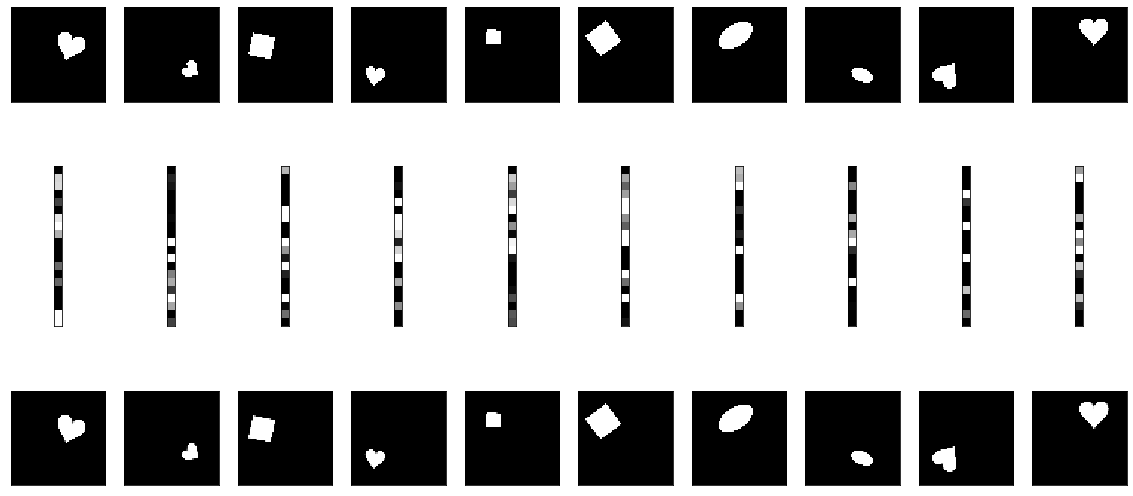

In [ ]:
def to_img(x):
    # convert a tensor vectorized image to a numpy image of shape 64 x 64
    if torch.is_tensor(x):
        x = x.cpu().data.numpy()
    x = x.reshape([-1, 64, 64])
    return x  
    

data, _ = next(iter(val_loader))
data.requires_grad = False
data = data.to(device)
true_imgs = data
encoded_imgs_mean, encoded_imgs_log_var = model.encode(data)
encoded_imgs_sampled = model.reparameterize(encoded_imgs_mean, encoded_imgs_log_var)
decoded_imgs = model.decode(encoded_imgs_sampled)
    
true_imgs = to_img(true_imgs)
decoded_imgs = to_img(decoded_imgs)
encoded_imgs_sampled = encoded_imgs_sampled.cpu().data.numpy()
    
n = 10
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(true_imgs[i], interpolation="nearest", 
                   vmin=0, vmax=1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs_sampled[np.newaxis,i,:].T, interpolation="nearest", 
                   vmin=0, vmax=1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n)
    plt.imshow(decoded_imgs[i], interpolation="nearest", 
                   vmin=0, vmax=1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()
    


## <font color=#33EBFF>Analyzing the  latent space's structure

In this section, from the VAE trained, we will propose a method to : <br>

(i) learn the subspace of the latent space which are encoding the factor of image variation (shape, scale, rotation, X and Y position) <br>

(ii) modify an image through its projection on the latent space

Let $i$ denote a factor of image variation (shape, scale, ...) and D<sub>i</sub> a subset of image created by varying only the factor of variation $i$. The elements of D<sub>i</sub> are labelled with the factors of variation. 
<br>
>Here is an exemple of D<sub>Y_position</sub> 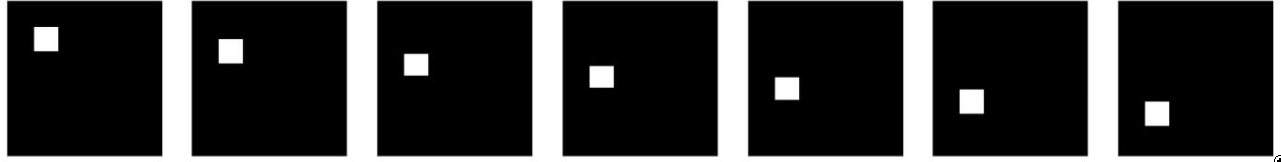

With the high regularity of this subset D<sub>i</sub> we expect that after going through the encoder, the latent vectors obtained from D<sub>i</sub> live in a subspace with less dimension than the latent space. 

>For example, for the subset D<sub>Y_position</sub>, we are just varying the Y_postion parameter so we expect the latent vectors living in a 1 dimension subspace.

Those subspace will be learned by PCA to retain 90% of the data variance. <br>

Let's call L : dimension of the latent space<br>
We assume that the subspace is characterized by its semi-orthogonal matrix $U_i \in \Re^{L×M_i}$, $1\leq M_i \leq L$ <br>
This matrix is the solution of this optimization problem: 
$$\min_{U\in\Re^{L×M_i} } \mathbb{E}_{p^i(x)}[ \lVert \lambda(x)-UU^T\lambda(x)\lVert_2^2 ]$$
Where : 
- $p^i$ is the empirical distribution associated with $D_i$<br>
- $\lambda$ is the mean fonction obtain after encoding an element x of the dataset $D_i$ 


Now let consider how to move the projection in this subspace learned by PCA.

Firstly, moving the projection in subspace toward a random direction(even a very small step) will lead to great distort in the output, here are demonstrations:


The picture below show the process of projecting 6 points (points 1,2,3,4,5,6 in 3D space) into PCA space (2D plane), where projections are noted as 1",2",3",4",5",6".

Now we move projection 1" (projection of point 1 in PCA space) toward a random direction in PCA space, like the random vector $g(y)$.

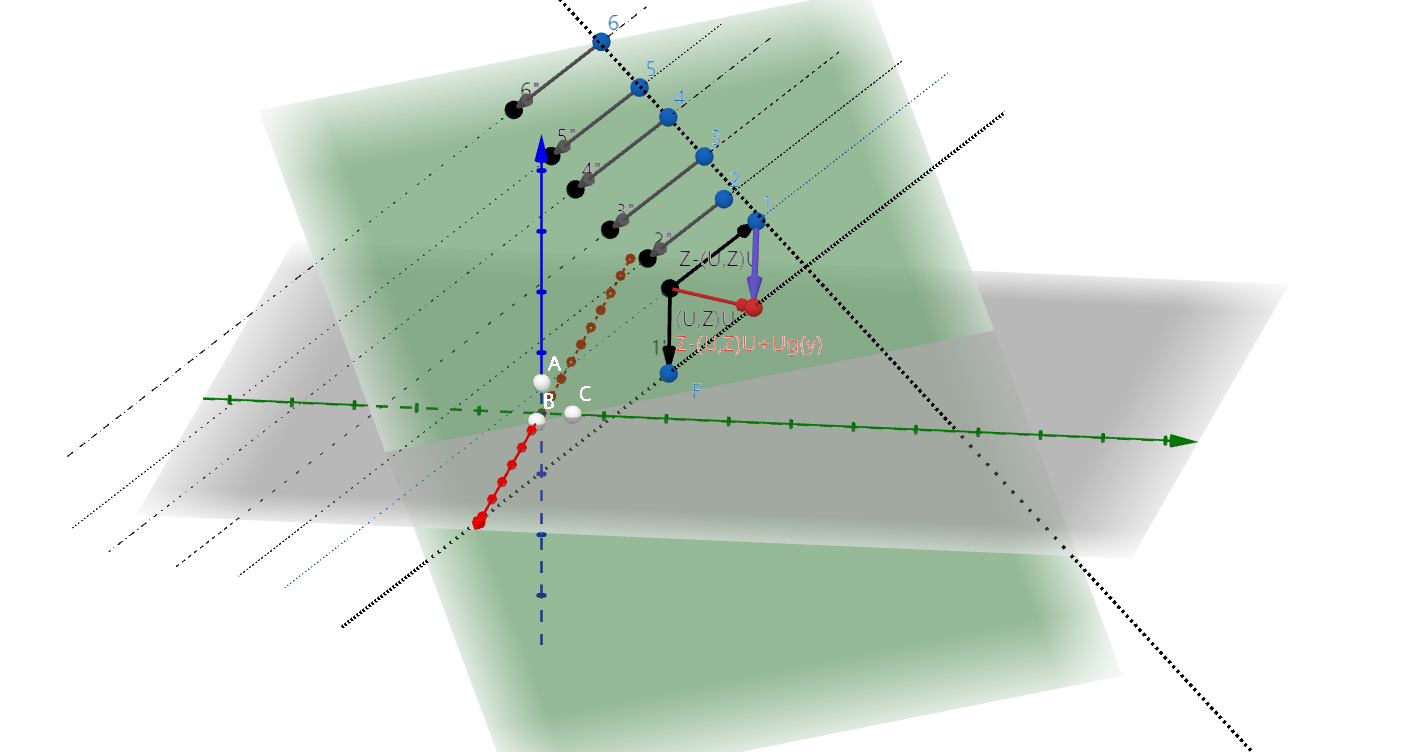

Red point that presents the re-projection of moved point 1" from PCA space to latent space.

Obviously, Red point is out of the line generated by the regression of the points in latent space(3D space), which in fact reflect the "hidden law" inside the set, for example, same size or same rotation angle.

In our example, the projection is not from 3D to 2D, but from 20D to 3D, it means that this divergence phenomenon will be much more severe

From the demonstration of a random move, now we deduce that we need to satisfy at least 2 principal when we choose $g(y)$:

1, $g(y)$ vector need to follow the "hidden law" inside the set

2, $g(y)$ vector can't be a constant vector since the distribution of the set may be non-linear



To apply transformations in the latent space, given a latent vector Z coming from the encoder, we apply this transformation : <br>
$$ Z_{modified} = Z - U_i*U_i^T*Z + U_i*g_i(y)$$ <br>
where y $\in \Re$ is the label, the value of the factor $i$<br> this transformation can be visualized if we suppose the dimension of latent space equal 2 with this picture : 
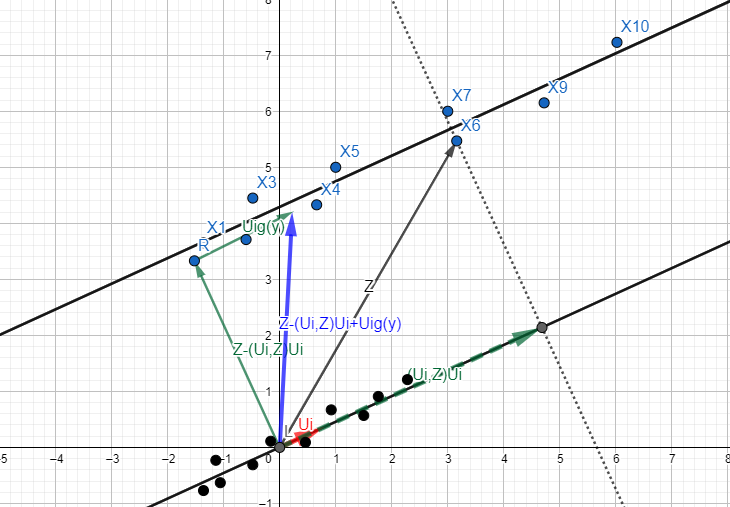


Regression in PCA space can solve the problem above. 

With a same set of examples, modifying an image with respect to the $i$ factor of variation, we do a piecewise linear regression between the labelled factor of variation $i$ and the components of the latents vectors projected in the space learned by PCA. <br>
Let's call $g_i$ : $ℜ\toℜ^{Mi}$ the fonction that regress from the labelled factor $i$ to the data coordinates in the subspace defined by $U_i$


In [ ]:
# Number of piece we want in the the piecewise linear regression 
N_piecewise_line = 5

Where the blue points represents the latent vectors coming from the encoding of the subset $D_i$, the black is obtained after normalizing and centering. 
<br> 
$Ui$ is the matrix $(2,1)$ here learned by PCA
<br> Z is a latent vector from $Di$

This method can be generalized under the assumption that two different dataset $D_{i,1}$ and $D_{i,2}$ with the same factor of variation $i$ but other fixed factor (ex: subset of oval moving on X and subset of square moving on X) have parrallel basis learned by pca.   <br>

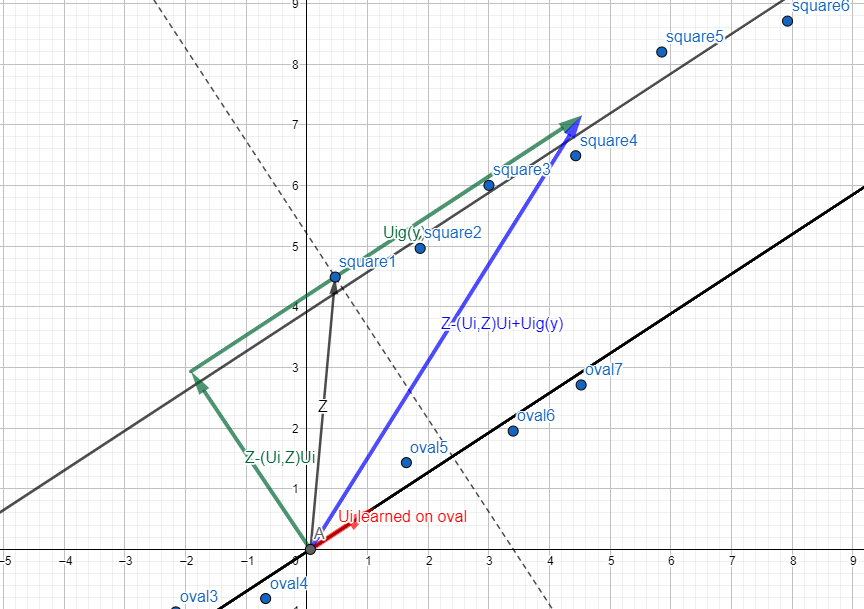

The following picture will show that if $D_{i,1}$ and $D_{i,2}$ has unparrallel basis the generalisation can not be achieved. 
<br> 
Indeed the vector $$ Z_{modified} = Z - U_i*U_i^T*Z + U_i*g_i(y)$$
will not be on the subspace generated by the dataset $D_{i,2}$ here the line generated by the squares.
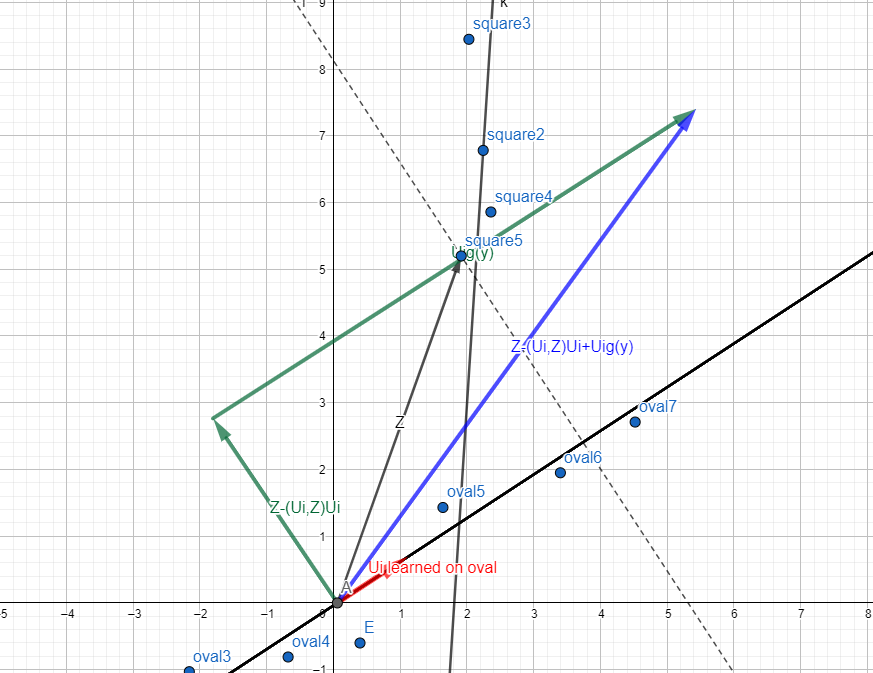

Reminder : latent_values shape: [ color ==1 , shape , scale , orientation , position X , position Y ]
<br>
All the authorized latent_values are in latent_dic <br>
for example all the values of position X:
<code>latent_dic['position X']</code>


In [ ]:
list(latent_dic['position X'])

[0.0,
 0.12903225806451613,
 0.06451612903225806,
 0.1935483870967742,
 0.25806451612903225,
 0.2903225806451613,
 0.4838709677419355,
 0.5161290322580645,
 0.5483870967741935,
 0.5806451612903226,
 1.0,
 0.3225806451612903,
 0.3870967741935484,
 0.45161290322580644,
 0.6451612903225806,
 0.7096774193548387,
 0.7741935483870968,
 0.8387096774193549,
 0.9032258064516129,
 0.03225806451612903,
 0.0967741935483871,
 0.16129032258064516,
 0.22580645161290322,
 0.967741935483871,
 0.3548387096774194,
 0.9354838709677419,
 0.41935483870967744,
 0.6129032258064516,
 0.6774193548387096,
 0.7419354838709677,
 0.8064516129032258,
 0.8709677419354839]

#### Utils functions

In [ ]:
def pick_1D_data(data=dataset,color=1,shape=1,scale=0.5,orientation=0,x=0,y=0, variable=[0,0,0,0,0,0]):
    """
    Pick a set of images from the initial dataset with only 1 dimension varying
    
    Parameters
    ----------
    data : dSpritesDataset = dataset
        the initial dataset 
    color : int = 1
        color we want for the images in the set (always 1 for the dSprites dataset)
    shape : int
        shape we want for the images in the set
        1 : square
        2 : ellipse
        3 : heart
    scale : float 
        scale of the images in the set
        values accepted in latent_dic['scale']
    orientation : float
        orientation of the images in the set
        values accepted in latent_dic['orientation']
    x : float
        position X of the images in the set
        alues accepted in latent_dic['position X']
    y : float
        position Y of the images in the set
        alues accepted in latent_dic['position Y']
    variable : list
        list of the parameters we want it varying in our set of images
        variable[0] : color
        variable[1] : shape
        variable[2] : scale
        variable[3] : orientation
        variable[4] : position X
        variable[5] : position Y
    
    Returns
    -------

    set_image : DataLoader
        The set of images
    variable : list
        list of the parameters varying in our set of images

    Example
    -------
    We want all the squares with a scale equal to 0.5, orientation equal to 0, position X equal to 0 and position Y varying :

    pick_1D_data(dataset,color=1,shape=1,scale=0.5,orientation=0,x=0,y=0, variable=[0,0,0,0,0,1])

    (y=0 doesn't matter here)
    """

    ref=[color,shape,scale,orientation,x,y]
    for var in range(len(variable)):
        if variable[var]==1:
            b=[]
            c=0
            for lat in data.latents_values:
                if np.array_equal(lat[:var],ref[:var]) and np.array_equal(lat[var+1:],ref[var+1:]):
                    b.append(c)
                c+=1
                set_image=DataLoader(torch.utils.data.Subset(dataset,b),shuffle=False,batch_size=64)
            return  set_image,variable
    return(None)

#loader,var=pick_1D_data(dataset,color=1,shape=1,scale=0.5,orientation=0,x=0,y=0, variable=[0,0,0,0,0,1])

def show_real(set_image,variable):
    """
    Show the images from the set of images
    
    Parameters
    ----------
    set_image : torch.utils.data.DataLoader
        loader of the set of images
    variable : list 
        list of the parameters varying in our set of images
    """

    plt.figure(figsize=(28,38))
    data,_ = next(iter(set_image))
    true_imgs = to_img(data)
    n=len(true_imgs)

    for i in range(n):
        # display original
        ax = plt.subplot(int(n/5)+1,5,i+1)
        plt.imshow(true_imgs[i], interpolation="nearest", 
                       vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    print(latent_index[variable.index(1)])



In [ ]:
def encode_and_normalize(set_image):
    """
    Encode the set of images and normalize it
        
    Parameters 
    ----------
    set_image : torch.utils.data.DataLoader
        set of images
               
    Returns
    -------
    scaler : 
        the function that scale with the mean and the var of the data
    scaled_mu : numpy.array
        set of encoded images in the latent space and normalized
    """
    data,_ = next(iter(set_image))
    scaler = StandardScaler()
    mu = model.encode(data)[0]
    mu = mu.cpu()
    mu = mu.detach().numpy()
    scale_mu = scaler.fit_transform(mu)  #normalize mu : mu-mean(mu)/std(mu)
    return scaler,scale_mu
    
def fitting_pca(scale_mu,percent=0.9):
    """
    Do PCA analysis on the set of "images" (the normalized encoded data)

    Parameters
    ----------
    scale_mu : numpy.array
        set of encoded images in the latent space and normalized

    Return
    ------
    pca : 
        A PCA function fit on the input data
        (90% of variance are setted as defaut)

    """

    pca = PCA(percent)
    pca.fit(scale_mu)
    print(f'pca{pca.explained_variance_ratio_}')
    return pca

In [ ]:
def projection_pca(pca,scale_mu):
    """
    Projection on the linear subspace formed by 
    projection sur le sous espace vect qui porte 90% de la variance du vecteur d'espérance
    
    Parameters
    ---------- 
    pca : 
        PCA function
    scale_mu : numpy.array
        normalized mu

    Returns
    -------
    projected_scale_mu: numpy.array
        Low dimension mu (generated by PCA analysis),
    n_row : int
        number of rows of projected_scale_mu (number of images)
    n_column: int
        number of columns of projected_scale_mu (number of orthogonal axis found by pca with 90% of the variance)

    """
    projected_scale_mu = pca.transform(scale_mu)
    n_row,n_column=projected_scale_mu.shape
    return projected_scale_mu,n_row,n_column


def linfit(variable,projected_scale_mu,n_column,threeD=False):
    """
    1 dimension regression on the projected scaled encoded images projected on n_row orthogonal axis

    Parameters
    ----------
    var : list
        The list of varying parameters in our set of images (for example position Y)  
    projected_scale_mu: numpy.array
        Low dimension mu
    n_column : int

    Return
    ------
    regression_pca :
        The regression found
    """

    plt.figure(figsize=(30,8))

    # Get the extremum values of the varying parameter
    x=np.sort(list(latent_dic[latent_index[variable.index(1)]]))
    x_hat_0 = np.linspace(x.min(), x.max(), 100)

    regression_pca=[pwlf.PiecewiseLinFit(x,projected_scale_mu.T[i]) for i in range(n_column)]

    # Regression
    for k in regression_pca:
        k.fit(N_piecewise_line)

    # Show the plot
    for i in range(n_column):
        ax=plt.subplot(1,n_column,i+1)
        y=regression_pca[i]
        ax.plot(x, projected_scale_mu.T[i], 'o')
        ax.plot(x_hat_0,y.predict(x_hat_0) , '-')
        ax.grid()
        ax.set_xlabel(f'x')
        ax.set_ylabel(f'y{i}')
        plt.title("Regression on the x,y,z-component of the subspace")
    plt.show()
    
    ##################################
    if threeD:
      i=0
      fig = plt.figure(figsize=(30,8))
      ax = fig.add_subplot(1,n_column,i+1, projection='3d')

      y = projected_scale_mu.T[i]
      z = projected_scale_mu.T[(i+1)%3]
      c = projected_scale_mu.T[(i+2)%3]
      
      img = ax.scatter(y, z, c, c=x,label=f"x", cmap=plt.winter())
      ax.set_xlabel(f'y{i}')
      ax.set_ylabel(f'y{(i+1)%3}')
      ax.set_zlabel(f'y{(i+2)%3}')
      ax.legend()
      fig.colorbar(img)
      """fig = plt.figure(figsize=(30,8))
      for i in range(n_column):
        ax = fig.add_subplot(1,n_column,i+1, projection='3d')

        y = projected_scale_mu.T[i]
        z = projected_scale_mu.T[(i+1)%3]
        c = projected_scale_mu.T[(i+2)%3]
      
        img = ax.scatter(x, y, z, c=c,label=f"y{(i+2)%3}", cmap=plt.winter())
        ax.set_xlabel('x')
        ax.set_ylabel(f'y{i}')
        ax.set_zlabel(f'y{(i+1)%3}')
        ax.legend()
        fig.colorbar(img)"""
      plt.show()
      print("Subspace projected on 2 axes")
    return regression_pca

In [ ]:
def move(projected_scale_mu,index_mu,values_param,regression_pca):
    """
    Change the value of the varying parameter of one of the images in the set

    Parameters
    ----------
    projected_scale_mu : numpy.array
    index_mu : list
        list of the indexes of the images we want to change 
    values_param : list
        list of the values we want for the varying parameter of the images we want to change
    regression_pca :

    Return
    ------
    moved_projected_scale_mu : numpy.array
        set of images with modification in the low dimension space formed by pca

    Example
    -------
    Assume that the varying parameter is Position Y

    index_mu = [3,6,2]
    values_param = [0.2,0.5,1]

    That mean we want to change the 4th image of the "projected_scale_mu" vector (means the 4th image of the set) to set its Y position to 0.2
                                    7th image of the "projected_scale_mu" vector (means the 7th image of the set) to set its Y position to 0.5
                                    3rd image of the "projected_scale_mu" vector (means the 3rd image of the set) to set its Y position to 1.0
    """ 

    
    # Get the extremum values of the varying parameter
    #maximum=max(latent_dic[latent_index[var.index(1)]])
    #minimum=min(latent_dic[latent_index[var.index(1)]])
    

    moved_projected_scale_mu=np.zeros_like(projected_scale_mu)
    
    #for all the images we want to change
    for i in range(len(index_mu)):

        # assert that the value we want is between the extremums
        #if minimum<=values_param[i]<=maximum:

            for j in range(len(moved_projected_scale_mu[0])):
                moved_projected_scale_mu[index_mu[i]][j] = projected_scale_mu[index_mu[i]][j]-regression_pca[j].predict(values_param[i])
        #else:
          #return "Incorrect value(s)"
    return moved_projected_scale_mu

In [ ]:
def decode_pca(pca,scale_mu,moved_projected_scale_mu,scaler):
    """
    Decode low dimension data(mu)
    
    Parameters
    ----------
    pca :
        PCA function
    scale_mu : numpy.array
        orgininal scaled mu
    moved_projected_scale_mu : numpy.array
        moved low dimension data(mu)
    scaler : 
        function to normalize mu

    Return
    ------
    decoded_imgs : torch.Tensor
        decoded modified images
    """

    modified_scale_mu = scale_mu-pca.inverse_transform(moved_projected_scale_mu)
    modified_scale_mu = scaler.inverse_transform(modified_scale_mu)
    modified_mu = torch.tensor(modified_scale_mu)
    decoded_imgs = to_img(model.decode(modified_mu))
    return decoded_imgs

In [ ]:
def show_change(decoded_imgs,set_image):  
    plt.figure(figsize=(30,15))
    data,_ = next(iter(set_image))
    encoded_imgs_mean, encoded_imgs_log_var = model.encode(data)
    encoded_imgs_sampled = model.reparameterize(encoded_imgs_mean, encoded_imgs_log_var)
    decoded = model.decode(encoded_imgs_sampled)
    true_imgs = to_img(data)
    decoded=to_img(decoded)
    n=len(decoded)
    for i in range(n):
        if i%5==0:
        
            ax = plt.subplot(3, n//5+2, i//5+1)
            plt.imshow(true_imgs[i], interpolation="nearest", 
                           vmin=0, vmax=1)
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        
            ax = plt.subplot(3,n//5+2, i//5+1+n//5+2)
            plt.imshow(decoded[i], interpolation="nearest", 
                           vmin=0, vmax=1)
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
                       
            ax = plt.subplot(3,n//5+2, i//5+1+n//5+2+n//5+2)
            plt.imshow(decoded_imgs[i], interpolation="nearest", 
                           vmin=0, vmax=1)
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    print("\n 1st row : real data \n 2nd row : generated data \n 3rd row : modified data")

###"Train" pca and regressions functions

Steps :

1. Choose $i$ the factor of image variation and get $D_i$
2. Encode the images of $D_i$ and normalize the latent vectors
3. Fit the pca function with the given data and project the data in the subspace found by pca
4. Find the piecewise linear regressions on the subspace

In [ ]:
def train_pca(color=1,shape=1,scale=0.5,orientation=0,x=0,y=0,variable=[0,0,0,0,0,1],percent=0.9):
    """
    Train pca function

    Parameters
    ----------
    color, shape, orientation, x, y of the set
    variable : list
        The varying parameters we want to train the pca on
    percent : float
    
    Return
    ------
    pca : 
        The pca function
    regression_pca :
        The regression
    """

    set_image,variable=pick_1D_data(dataset,color,shape,scale,orientation,x,y, variable)

    scaler,scale_mu=encode_and_normalize(set_image)
    
    pca=fitting_pca(scale_mu,percent)

    projected_scale_mu,n_row,n_column=projection_pca(pca,scale_mu)

    regression_pca=linfit(variable,projected_scale_mu,n_column,threeD=True)

    return pca,regression_pca
    

###Modify image function along one factor with the subspace and regressions learned 

Steps :    
1. Choose the set and the images in the set we want to modify with their values
2. Encode and normalize
3. Project the set of vectors in the subspace
4. With the regression, "replace" the value of the factor in the subspace
5. bring the vector back to the latent space
6. decode the image


In [ ]:
def modify_img(color=1,shape=2,scale=0.5,orientation=0,x=0,y=0,variable=[0,0,0,0,0,1],index_mu=[0],values_param=[1],pca=0,regression_pca=0):
    """
    Modify and show the set of images
    """
    set_image,variable=pick_1D_data(dataset,color,shape,scale,orientation,x,y, variable)
    
    scaler,scale_mu=encode_and_normalize(set_image)
    
    projected_scale_mu,n_row,n_column=projection_pca(pca,scale_mu)
    
    moved_projected_scale_mu=move(projected_scale_mu,index_mu,values_param,regression_pca)
    
    decoded_imgs=decode_pca(pca,scale_mu,moved_projected_scale_mu,scaler)
    
    show_change(decoded_imgs,set_image)

###Train + modify on a random set

Here we learn the subspace (+ regressions) formed by squares (all set to color=1, scale =0.5, orientation= 0, position_X=0) varying along the Y_parameter.

pca[0.49241075 0.3887721  0.06196134]


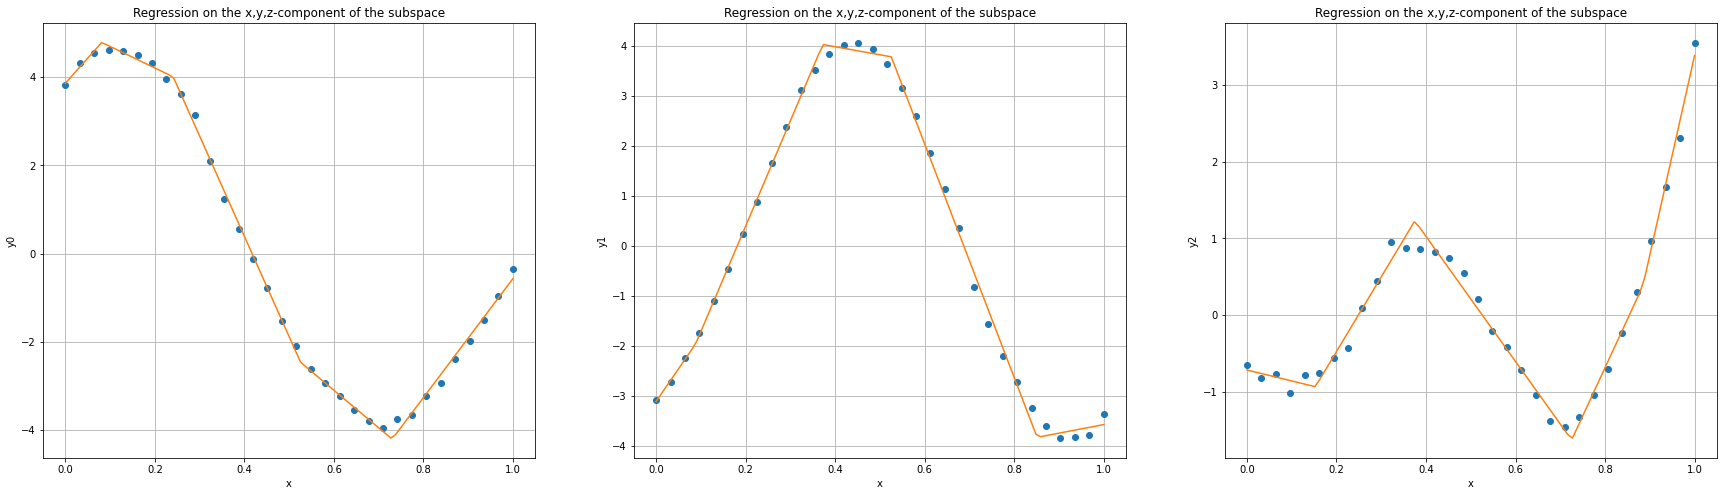

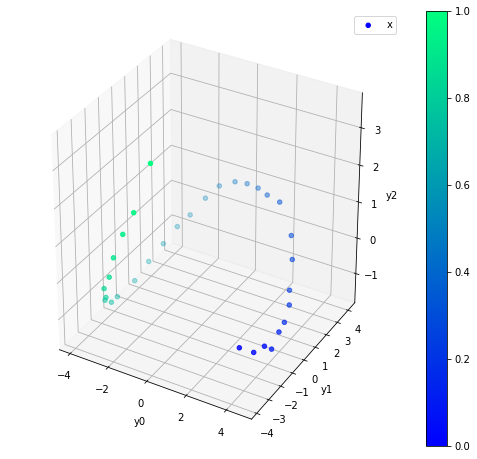

Subspace projected on 2 axes

 1st row : real data 
 2nd row : generated data 
 3rd row : modified data


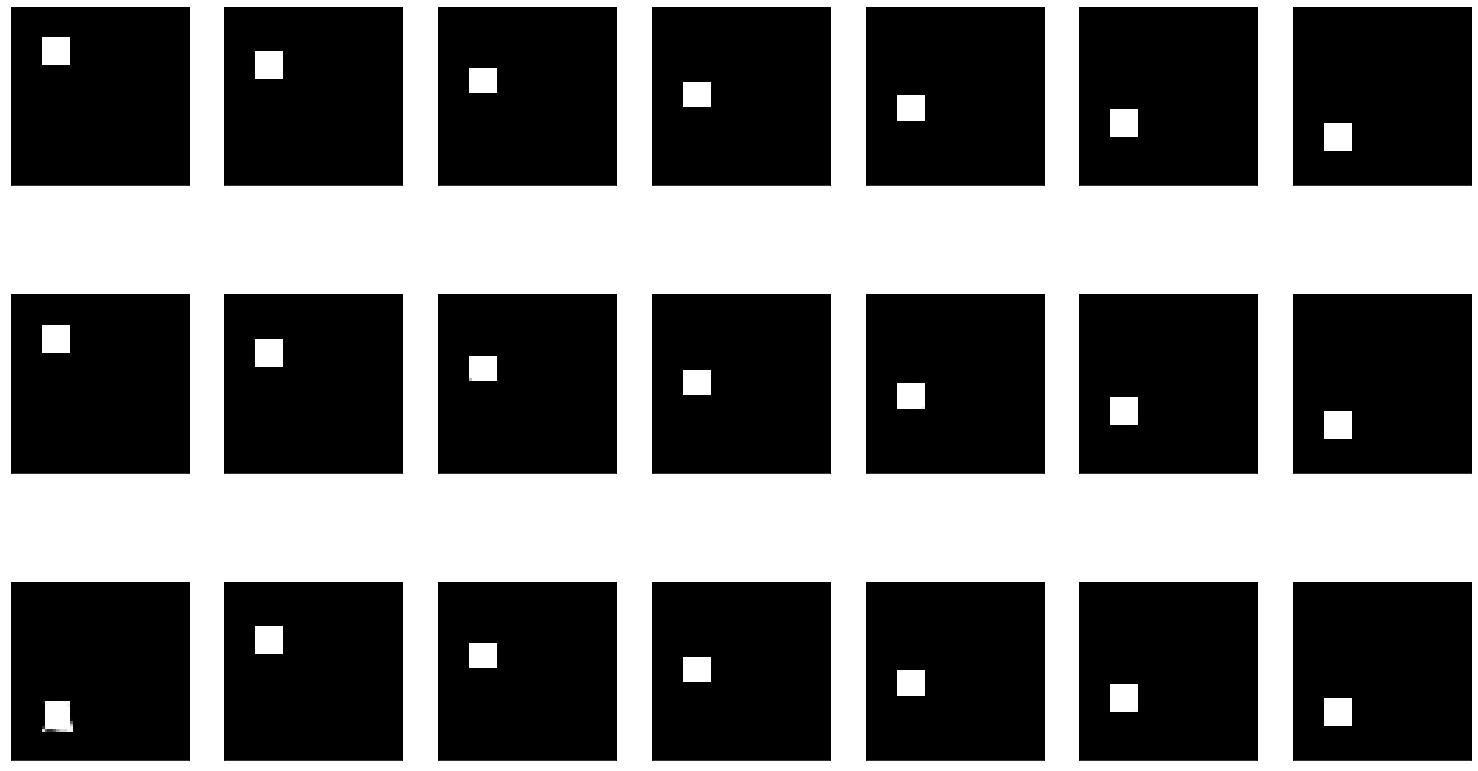

In [ ]:
if __name__=="__main__":
    pca,regression_pca=train_pca(color=1,shape=1,scale=0.5,orientation=0,x=0,y=0,variable=[0,0,0,0,0,1],percent=0.9)
    modify_img(color=1,shape=1,scale=0.5,orientation=0,x=0,y=0,variable=[0,0,0,0,0,1],index_mu=[0],values_param=[1],pca=pca,regression_pca=regression_pca)

The results of the training are quite good, in that way, we succeed to move down our first square. Now we want a generalisation of the result : modify the Y_position of ellipse, heart, other square,... with that learned subspace

scale : 0.8, orientation : 5.47764872933605° , x : 0.12903225806451613
0.7953399613497806

 1st row : real data 
 2nd row : generated data 
 3rd row : modified data


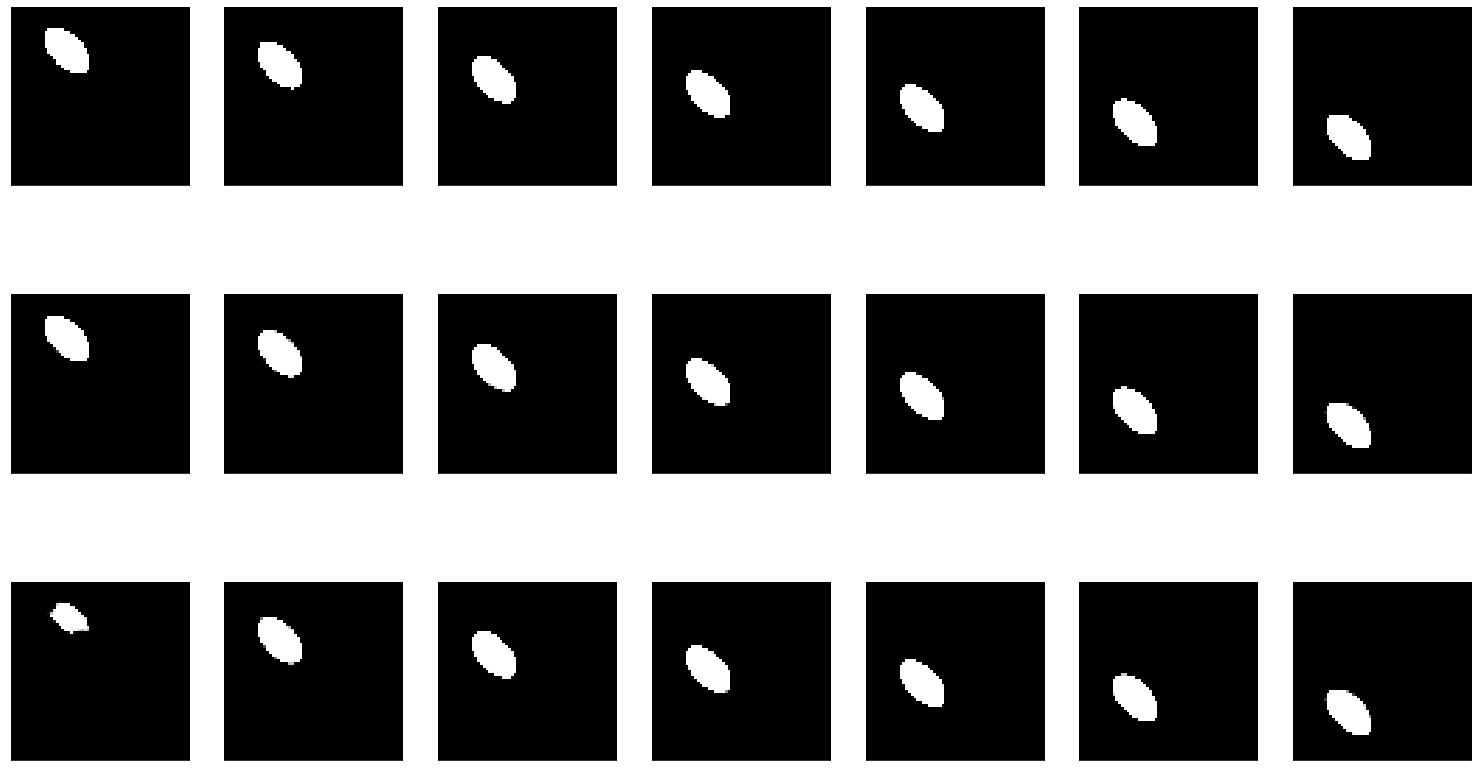

In [ ]:
#modify the first image of a random set of image to get its Y position at a random value

scales=list(latent_dic['scale'])
orientations=list(latent_dic['orientation'])
positions_x=list(latent_dic['position X'])

a=np.random.randint(1,4)
b=np.random.randint(len(scales))
c=np.random.randint(len(orientations))
d=np.random.randint(len(positions_x))
e=np.random.random()

print(f'scale : {scales[b]}, orientation : {orientations[c]}° , x : {positions_x[d]}')
print(e)

modify_img(color=1,shape=a,scale=scales[b],orientation=orientations[c],x=positions_x[d],y=0,variable=[0,0,0,0,0,1],index_mu=[0],values_param=[e],pca=pca,regression_pca=regression_pca)

The results here are pretty bad, the image we changed has not the same shape and its Y_position haven't really moved to the given value. It seems that generalisation failed. Let's check that quantitatively.

###Analyses of the generalization property


Here we will check if the basis learned on a 2 differents dataset (square and ellipse) such that the only factor of variation moving is Y have the vector of their basis learned by pca parrallel. 


pca[0.49241075 0.3887721  0.06196134]


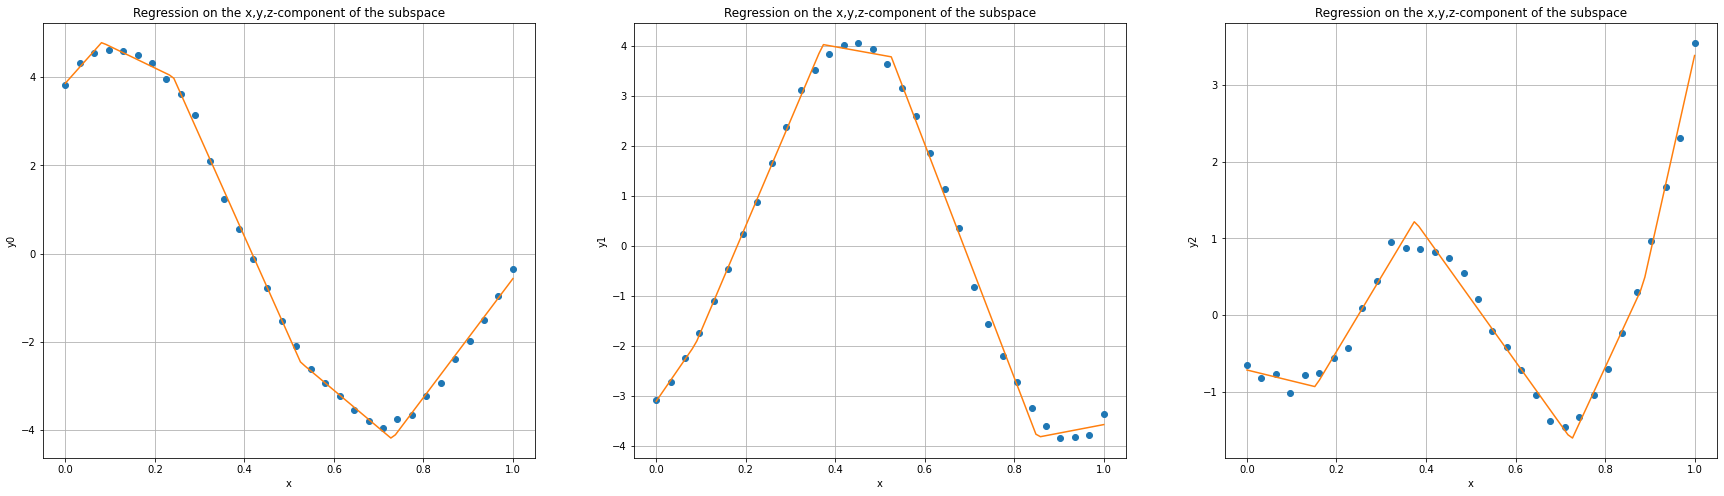

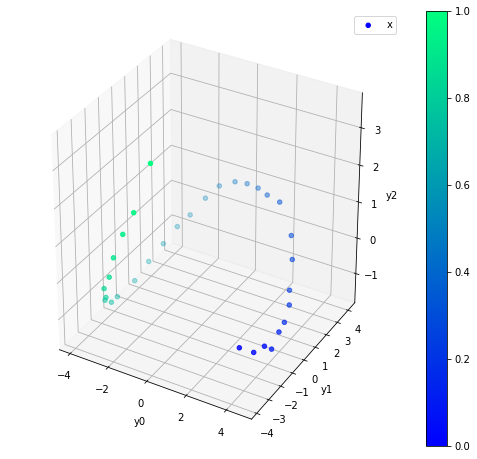

Subspace projected on 2 axes
pca[0.39262226 0.3740993  0.16390333]


/usr/local/lib/python3.7/dist-packages/pwlf/pwlf.py:1090: RuntimeWarning: invalid value encountered in true_divide
  self.fit_breaks[:self.n_segments]))


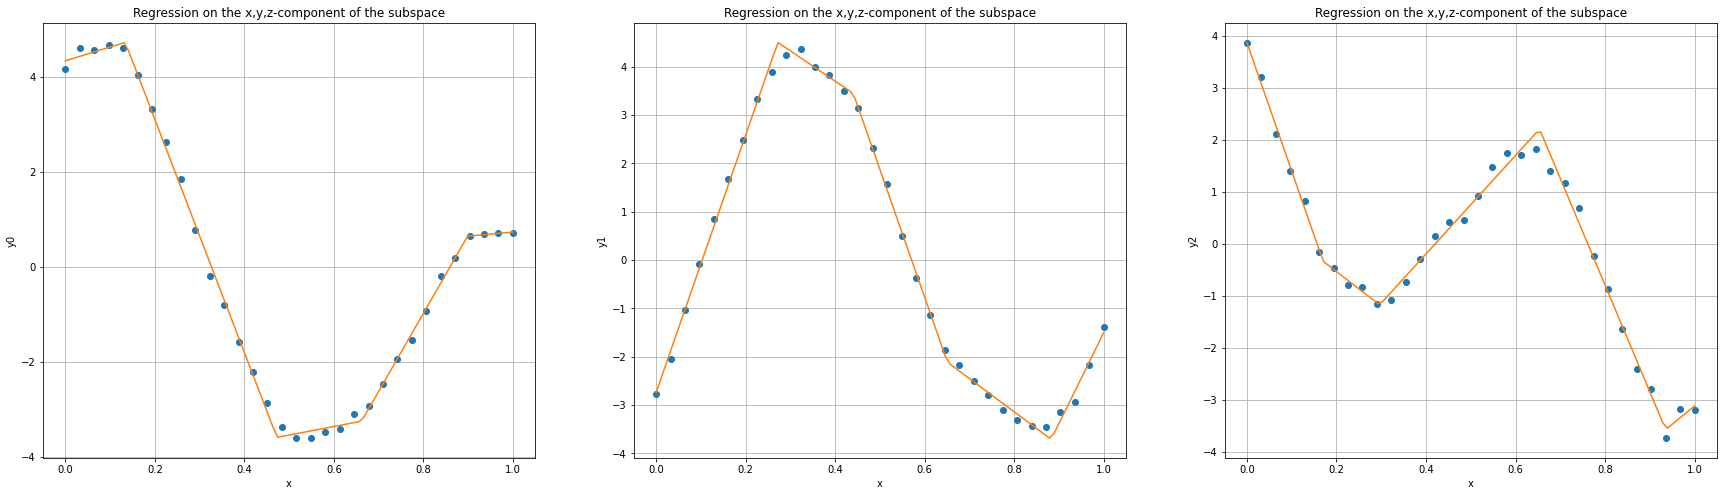

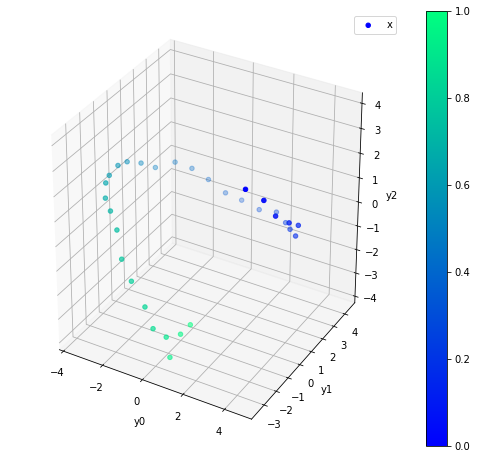

Subspace projected on 2 axes


In [99]:
pca_1,_=train_pca(color=1,shape=1,scale=0.5,orientation=0,x=0,y=0,variable=[0,0,0,0,0,1],percent=0.9)  #square
pca_2,_=train_pca(color=1,shape=2,scale=0.5,orientation=0,x=0,y=0,variable=[0,0,0,0,0,1],percent=0.9)  #ellipse


- The subspace learned on square is formed by <br>
(pca_1.components_[0], pca_1.components_[1], pca_1.components_[1]) = ($c_1$,$c_2$,$c_3$)

- The subspace learned on ellipse is formed by <br>
(pca_2.components_[0], pca_2.components_[1], pca_2.components_[1]) = ($e_1$,$e_2$,$e_3$)
<br>

Let $K$ be the matrix defined by $(K_{ij})_{i,j}$  such as $c_i = K_{ij}.e_j$



In [105]:
c1,c2,c3= pca_1.components_
e1,e2,e3= pca_2.components_

K = np.array([[pca_1.components_[i]/pca_2.components_[j] for j in range(3)] for i in range(3)])


print(K)

[[[ 5.83726764e-01  1.68787920e+00  6.29214406e-01  4.53905202e-02
   -4.91232127e-02  1.16157663e+00 -3.24095321e+00 -1.18228996e+00
    6.67529345e-01  1.02482569e+00  1.05121076e+00  2.32561026e-02
   -6.28772497e+00  2.51517344e+00  1.92591631e+00  8.72456014e-01
    7.84436524e-01  9.09760296e-01  1.33117771e+00  1.12742376e+00]
  [ 5.75069332e+00 -2.95821595e+00 -2.48950720e+00  4.17051129e-02
    2.39174943e-02  1.34715486e+00  7.70718992e-01  2.98423395e-02
   -6.71572387e-01  1.92764997e+00  1.54926467e+00 -3.00151985e-02
    4.71183002e-01  5.53780556e-01 -4.95476103e+00 -2.23292961e+01
   -6.13368928e-01  2.25118988e+02  5.72086453e-01  1.37806499e+00]
  [-6.18999660e-01  6.71316385e-01 -9.07146335e-01 -1.79843903e-02
    8.23808610e-02  4.81259680e+00  1.91083026e+00 -6.52297661e-02
    4.41533899e+00  1.71841764e+00  1.71681747e+01 -2.04688981e-02
   -2.65730238e+00 -1.95195401e+00  6.28419280e-01  1.81233335e+00
    1.27142370e+00 -1.31372523e+00  4.27823067e-01  1.553943

There is any constant list, there is no proportionnal $e_i$ and $c_j$.

Let's confirm it with the variance of each list

In [111]:
K_v=np.array([[np.var(pca_1.components_[i]/pca_2.components_[j]) for j in range(3)] for i in range(3)])
print(K_v)

[[   3.6351547 2457.5283    1142.054    ]
 [  79.18397    223.44736      6.800489 ]
 [  22.542723  1768.7369     196.7      ]]


Even if there are extreme values, we can say that the vector are not parrallel, thus the modification learned on a subspace can not be generalized. 

###Analyses of the independent behaviour

We want to see if we can change independently the different factors 
>For example change the Y_position without changing X_position

pca[0.49241075 0.3887721  0.06196134]


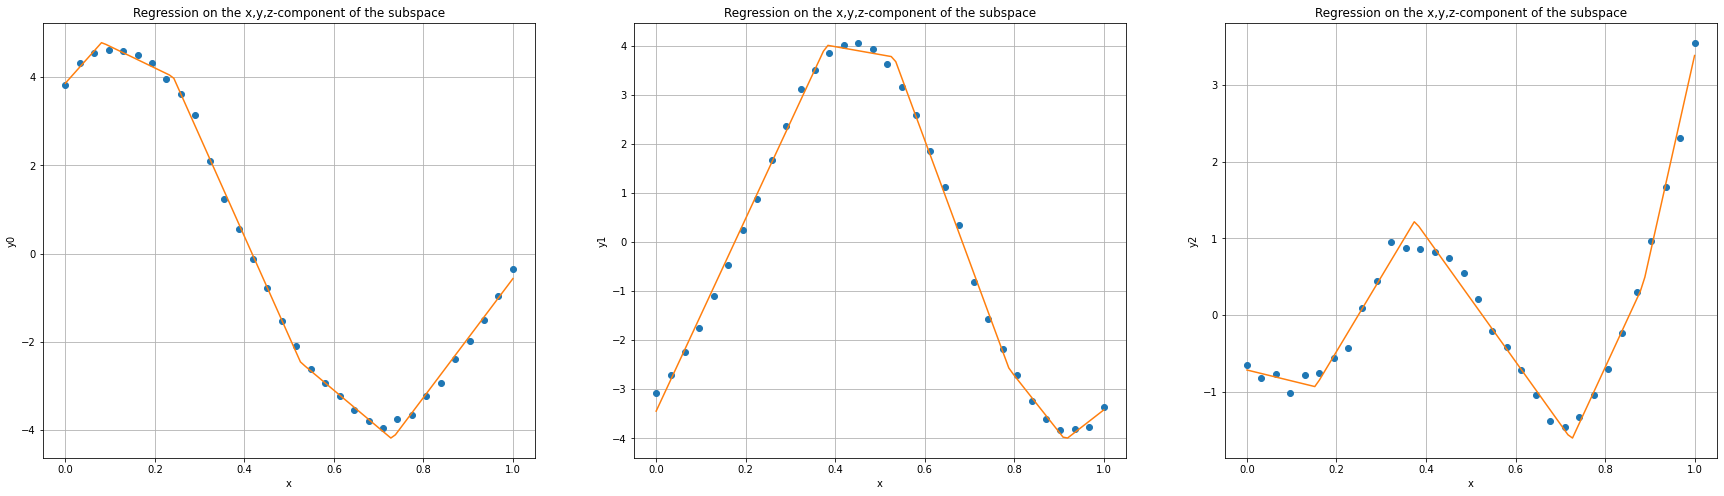

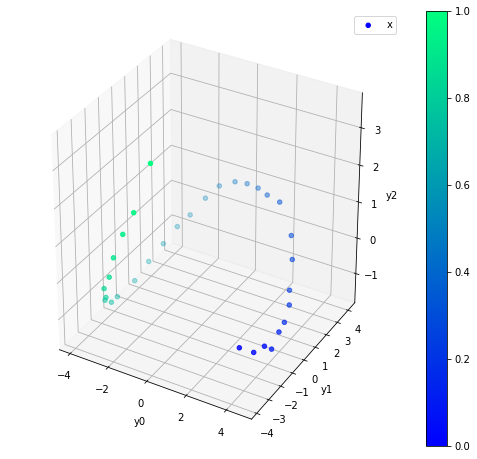

Subspace projected on 2 axes
pca[0.45665115 0.41719592 0.08782372]


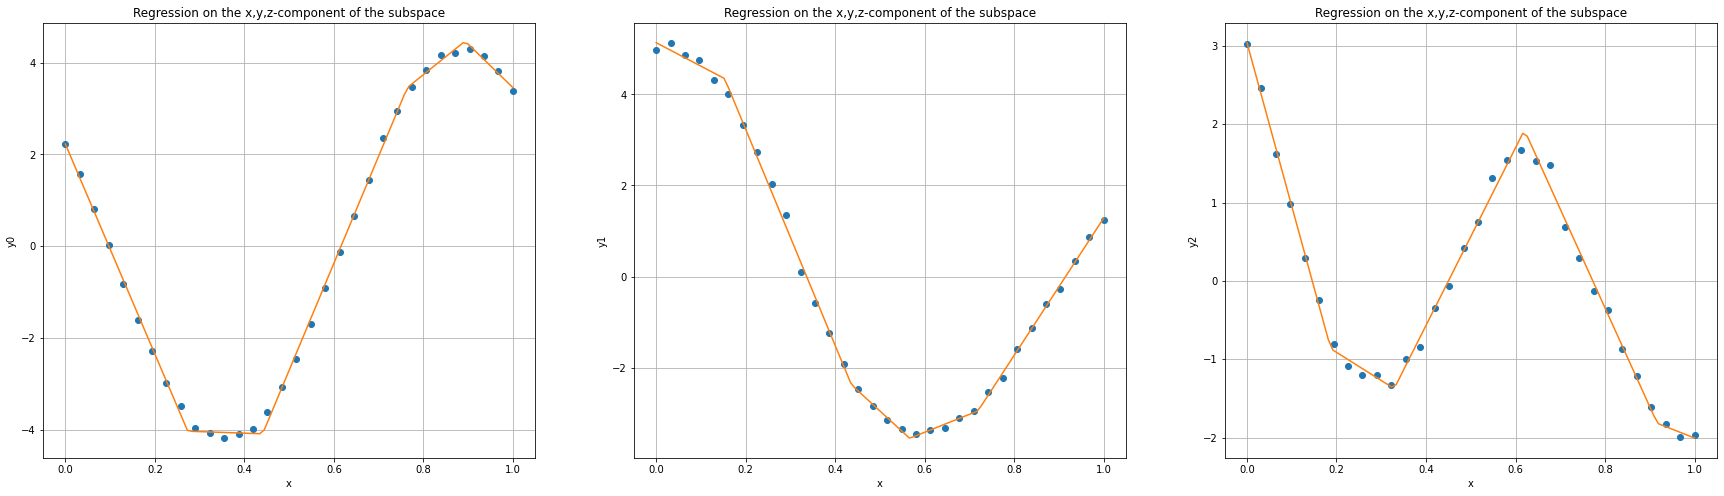

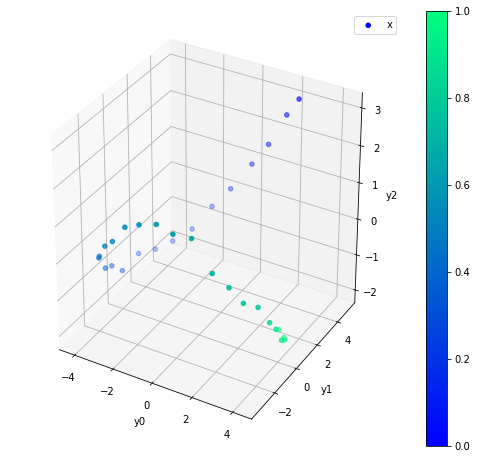

Subspace projected on 2 axes


In [112]:
pca_y,_=train_pca(color=1,shape=1,scale=0.5,orientation=0,x=0,y=0,variable=[0,0,0,0,0,1],percent=0.9)  
pca_x,_=train_pca(color=1,shape=1,scale=0.5,orientation=0,x=0,y=0,variable=[0,0,0,0,1,0],percent=0.9)  

- The subspace learned on square varying on y is formed by <br>
(pca_y.components_[0], pca_y.components_[1], pca_y.components_[1]) = ($y_1$,$y_2$,$y_3$)

- The subspace learned on square varying on x is formed by <br>
(pca_x.components_[0], pca_x.components_[1], pca_c.components_[1]) = ($x_1$,$x_2$,$x_3$)
<br>

Let $M$ be the matrix defined by $(M_{ij})_{i,j}$  such as $M_{ij}=x_i.y_j$

In [114]:
x1,x2,x3=pca_x.components_
y1,y2,y3=pca_y.components_

M=np.array([[np.dot(pca_x.components_[i],pca_y.components_[j]) for j in range(3)] for i in range(3)])

print(M)

[[ 0.4134278   0.06766589  0.19887193]
 [ 0.5852663  -0.5647571  -0.1843548 ]
 [ 0.19757132 -0.15291595 -0.04150461]]


We can see that there is not a perfect independence (all terms equal to 0) but we are pretty close to it.


###Test zone (ignore)

In [ ]:
color=1
shape=1
scale=0.8
orientation=0
x=0
y=0
variable=[0,0,0,0,0,1]
index_mu=[0]
values_param=[1]

color_train=1
shape_train=1
scale_train=0.5
orientation_train=0
x_train=0
y_train=0
variable_train=[0,0,0,0,0,1]
index_mu_train=[0]
values_param_train=[1]

set_image_train,variable=pick_1D_data(dataset,color_train,shape_train,scale_train,orientation_train,x_train,y_train, variable_train)
   
scaler_train,_=encode_and_normalize(set_image_train)




set_image,variable=pick_1D_data(dataset,color,shape,scale,orientation,x,y, variable)

data,_ = next(iter(set_image))
mu = model.encode(data)[0]
mu = mu.cpu()
mu = mu.detach().numpy()

scale_mu = scaler_train.fit_transform(mu)


scaler,scale_mu=encode_and_normalize(set_image)
projected_scale_mu,n_row,n_column=projection_pca(pca,scale_mu)
print(projected_scale_mu[0])
moved_projected_scale_mu=move(projected_scale_mu,index_mu,values_param,regression_pca)

modified_scale_mu = scale_mu-pca.inverse_transform(moved_projected_scale_mu)
modified_scale_mu = scaler.inverse_transform(modified_scale_mu)
modified_mu = torch.tensor(modified_scale_mu)

modified_mu1=torch.Tensor(mu-scaler.inverse_transform(pca.inverse_transform(moved_projected_scale_mu)))
tensorA=modified_mu
tensorB=modified_mu1
print(torch.equal(tensorA, tensorB))

In [ ]:
print(tensorA-tensorB)